# Deep Learning and Inverse Problems - Summer 2024
## Problem Set 4

**Issued**: Tuesday, May 7, 2024, 1:00 pm

**Due**: Tuesday, May 14, 2024, 1:00 pm

# Denoising Images with a U-Net

In this homework, your task is to train a U-Net for image denoising using PyTorch. As dataset, we use the Berkeley Segmentation Dataset (BSDS300). This dataset contains 300 clean color images. For simplicity, we consider Gaussian noise and convert the images to grayscale (see below). The attached file `unet.py` contains a PyTorch implemenation of the U-Net for you to use.

In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
import tqdm
from matplotlib import pyplot as plt
import numpy as np
import math

from unet import Unet

# Download Dataset
Running these commands in the terminal downloads the BSDS300 dataset as a `.tgz` file, unzip it and delete the `.tgz` file.

In [3]:
#!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
#!tar -xvzf BSDS300-images.tgz
#!rm BSDS300-images.tgz

# Build PyTorch Datasets and Dataloaders

We use all 200 images in `./BSDS300/images/train` for training. The first 50 images in `./BSDS300/images/test` are used for validation and the remaining 50 for testing.

In [4]:
dataset_dir = "./BSDS300"

train_set_dir = f"{dataset_dir}/images/train"
train_img_files = [f"{train_set_dir}/{filename}" for filename in os.listdir(train_set_dir)]
# use this to train with fewer data
# train_img_files = random.sample(train_img_files, 50)

test_set_dir = f"{dataset_dir}/images/test"
test_img_files = [f"{test_set_dir}/{filename}" for filename in os.listdir(test_set_dir)]
val_img_files = test_img_files[:50]
test_img_files = test_img_files[50:]

## Problem 1 + Solution
We first implement a `torch.utils.data.Dataset` that returns pairs of noisy images and clean ground truth. 

Complete the code below so that the dataset returns images that are **grayscale** (BSDS contains RGB images, so you have to convert them) with pixel-range $[0,1]$. Add zero-mean Gaussian noise with variance `noise_var` to the clean images. To reduce computational cost, we also want to be able to use chunks instead of full-sized images for training. Therefore, implement code to split an image into non-overlapping chunks of size `(chunk_size, chunk_size)`. For example: An image of size `(512, 512)` should be split into 16 non-overlapping chunks of size `(128,128)`. If any of the image dimension is not divisible by `chunk_size`, simply crop the dimension until it is divisble by `chunk_size`. For reference: If you split all 200 train images into chunks of size `(128,128)`, you should end up with 1200 chunks.

In [5]:
# load image from file, convert to grayscale and normalize to range [0,1]
def load_img(file):
    # open image as grayscale
    img = Image.open(file).convert("L")
    img = torch.tensor(np.array(img))
    # convert to range [0,1]
    img = img / 255.
    return img

# split an image into chunks of size chunk_size x chunks_size (no padding, no overlap)
def chunk_img(img, chunk_size):
    chunks = img.unfold(0, chunk_size, chunk_size).unfold(1, chunk_size, chunk_size).reshape(-1, chunk_size, chunk_size)
    return list(chunks)

In [6]:
class NoisyImageChunkDataset(Dataset):
    def __init__(self, img_files, noise_var, chunk_size):
        self.img_files = img_files
        self.noise_var = noise_var
        self.chunk_size = chunk_size
        self.chunks_clean, self.chunk_noisy = self.get_clean_and_noisy_chunks()

    def get_clean_and_noisy_chunks(self):
        # load clean images
        imgs_clean = [load_img(file) for file in self.img_files]
        # split into chunks
        chunks_clean = sum([chunk_img(img, chunk_size=self.chunk_size) for img in imgs_clean], [])
        # add noise to chunks
        chunks_noisy = [img + math.sqrt(self.noise_var) * torch.randn_like(img) for img in chunks_clean]
        return chunks_clean, chunks_noisy

    def __len__(self):
        return len(self.chunks_clean)

    def __getitem__(self, idx):
        return self.chunk_noisy[idx], self.chunks_clean[idx]

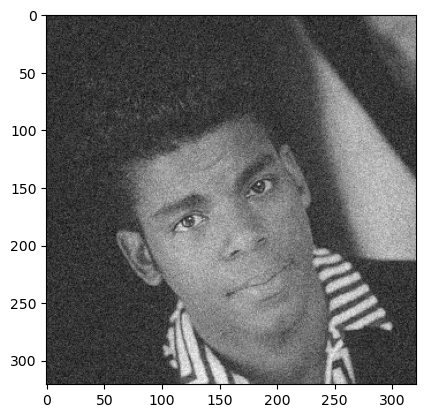

In [7]:
noise_var = 0.005  # more noise makes denoising harder, we suggest you keep this value
train_chunk_size = 128  # depends on your hardware; we recommend 128

train_set = NoisyImageChunkDataset(img_files=train_img_files, noise_var=noise_var, chunk_size=train_chunk_size)
# for validation and testing, we do not have to split the images into chunks because we do not have to compute gradients
# the images have shape (321, 481) or (481, 321) so we crop them to (321, 321) to facilitate data loading
val_set = NoisyImageChunkDataset(img_files=val_img_files, noise_var=noise_var, chunk_size=321)
test_set = NoisyImageChunkDataset(img_files=test_img_files, noise_var=noise_var, chunk_size=321)

plt.imshow(val_set[0][0], cmap="gray")

In [8]:
batch_size = 32  # depends on your hardware

train_loader = DataLoader(train_set, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

In [9]:
# more pooling layers and convolutional kernels increase the complexity of the U-Net (see lecture notes)
num_pool_layers = 2
chans = 64
device = "cpu"  # set to "cuda" or "cuda:0" if you have access to a GPU (e.g. via Google Colab)

model = Unet(
    in_chans=1,  # 1 input channel as we use grayscale images as input
    out_chans=1,  # 1 output channel as the model returns grayscale images
    num_pool_layers=num_pool_layers,
    chans=chans
)
model = model.to(device)

## Problem 2 + Solution

Choose a suitable loss for training and implement the trainig loop. Be sure to also check the validation loss (or PSNR) every few epochs to be sure that your model does not overfit.

Hint: In deep learning it is often helpful to normalize the data before passing it through the model. In image-to-image tasks (such as denoising), we often also de-normalize the model output to map the pixels back into the original range. For example:
````
mean, std = mean(img_noisy), std(img_noisy)
img_noisy = (img-mean) / std
img_denoised = model(img_noisy)
img_denoised = img_denoised * std + mean
````
An intuition behind this is that the model can then receive and return images in a fixed range which makes learning easier. Feel free to train your model with and without normalization to see if it makes a difference.

### Helper Functions

In [10]:
# psnr(img1, img2) = 10 * log10( max_pixel_value^2 / mean_square_error(img1, img2) )
# as we normalized all images to range [0,1], we have that max_pixel_value = 1 and the above formula reduces to
# psnr(img1, img2) = -10 * log10( mean_square_error(img1, img2) )
def get_psnr(gt, pred):
    pred = pred.clamp(0, 1)  # clamp prediction pixel range to range [0,1]
    mse = (gt-pred.clamp(0, 1)).pow(2).mean(dim=(-1,-2))
    return -10 * torch.log10(mse)  # psnr reduces to this formula as we normlaized the images to range [0,1]

def get_training_loss(imgs0, imgs1):
    return (imgs0 - imgs1).pow(2).mean(dim=(-1,-2))

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # choose a suitable optimizer form torch.optim; we recommend to use the ADAM optimizer

epochs = 5  # how many epochs to train
check_val_every_epochs = 1


for e in range(epochs):
    train_loss = 0.0
    for imgs_noisy, imgs_clean in tqdm.tqdm(train_loader, desc=f"Training Epoch {e}"):
        imgs_noisy = imgs_noisy.to(device)
        imgs_clean = imgs_clean.to(device)
        # clear the gradients
        optimizer.zero_grad()
        # normalize input
        mean = imgs_noisy.mean(dim=(-1, -2), keepdim=True)
        std = imgs_noisy.std(dim=(-1, -2), keepdim=True)
        imgs_noisy = (imgs_noisy - mean) / std
        # forward pass
        imgs_denoised = model(imgs_noisy.unsqueeze(1)).squeeze(1)
        # undo normalizaiton
        imgs_denoised = imgs_denoised * std + mean
        # find the Loss
        loss = get_training_loss(imgs_clean, imgs_denoised).mean()
        # calculate gradients 
        loss.backward()
        # update Weights
        optimizer.step()
        # update epoch loss
        train_loss += loss.item() # Since it is a torch tensor, we need to use .item() to get the value
    train_loss /= len(train_loader)
    print(f'Training Loss: {train_loss}')
    
    if e % check_val_every_epochs == 0:
        with torch.no_grad():
            val_psnr = 0.0
            for imgs_noisy, imgs_clean in tqdm.tqdm(val_loader, desc=f"Validation Epoch {e}"):
                imgs_noisy = imgs_noisy.to(device)
                imgs_clean = imgs_clean.to(device)
                mean = imgs_noisy.mean(dim=(-1, -2), keepdim=True)
                std = imgs_noisy.std(dim=(-1, -2), keepdim=True)
                imgs_noisy = (imgs_noisy - mean) / std
                imgs_denoised = model(imgs_noisy.unsqueeze(1)).squeeze(1)
                imgs_denoised = imgs_denoised * std + mean
                psnr = get_psnr(imgs_clean, imgs_denoised).mean()
                val_psnr += psnr.item()
            val_psnr /= len(val_loader)
            print(f'Validation PSNR: {val_psnr}')

Training Epoch 0: 100%|██████████| 38/38 [04:23<00:00,  6.93s/it]


Training Loss: 0.004773949052354223


Validation Epoch 0: 100%|██████████| 2/2 [00:21<00:00, 10.59s/it]


Validation PSNR: 26.336381912231445


Training Epoch 1: 100%|██████████| 38/38 [04:15<00:00,  6.71s/it]


Training Loss: 0.0021479366481990405


Validation Epoch 1: 100%|██████████| 2/2 [00:20<00:00, 10.07s/it]


Validation PSNR: 27.116324424743652


Training Epoch 2: 100%|██████████| 38/38 [04:03<00:00,  6.41s/it]


Training Loss: 0.00188391103323451


Validation Epoch 2: 100%|██████████| 2/2 [00:18<00:00,  9.34s/it]


Validation PSNR: 27.482431411743164


Training Epoch 3: 100%|██████████| 38/38 [04:03<00:00,  6.40s/it]


Training Loss: 0.0017532729727559183


Validation Epoch 3: 100%|██████████| 2/2 [00:18<00:00,  9.39s/it]


Validation PSNR: 27.721384048461914


Training Epoch 4: 100%|██████████| 38/38 [04:02<00:00,  6.38s/it]


Training Loss: 0.0016703737936423796


Validation Epoch 4: 100%|██████████| 2/2 [00:18<00:00,  9.49s/it]

Validation PSNR: 27.895265579223633


## Problem 3 + Solution
Test your model on the `test_loader`. Use suitable image metrics (e.g. PSNR, SSIM) to quantitatively assess the denoising performance of your model.

In [12]:
with torch.no_grad():
    test_psnr = 0.0
    base_psnr = 0.0
    for imgs_noisy, imgs_clean in tqdm.tqdm(test_loader, desc="Testing"):
        imgs_noisy = imgs_noisy.to(device)
        imgs_clean = imgs_clean.to(device)
        mean = imgs_noisy.mean(dim=(-1, -2), keepdim=True)
        std = imgs_noisy.std(dim=(-1, -2), keepdim=True)
        imgs_noisy = (imgs_noisy - mean) / std
        imgs_denoised = model(imgs_noisy.unsqueeze(1)).squeeze(1)
        imgs_denoised = (imgs_denoised * std) + mean
        test_psnr += get_psnr(imgs_clean, imgs_denoised).mean().item()
        base_psnr += get_psnr(imgs_clean, imgs_noisy).mean().item()
    test_psnr /= len(test_loader)
    base_psnr /= len(test_loader)
    print(f"PSNR of noisy images: {base_psnr}")
    print(f'PSNR of denoised images: {test_psnr}')

Testing: 100%|██████████| 2/2 [00:18<00:00,  9.38s/it]

PSNR of noisy images: 10.638391017913818
PSNR of denoised images: 27.92861270904541


## Self-Supervised Learning

Change the Dataset and Dataloader

In [24]:
class Noisy2NoisyImageChunkDataset(Dataset):
    def __init__(self, img_files, noise_var, chunk_size):
        self.img_files = img_files
        self.noise_var = noise_var
        self.chunk_size = chunk_size
        self.chunks_clean, self.chunk_noisy = self.get_clean_and_noisy_chunks()

    def get_clean_and_noisy_chunks(self):
        # load clean images
        imgs_clean = [load_img(file) for file in self.img_files]
        # split into chunks
        chunks_clean = sum([chunk_img(img, chunk_size=self.chunk_size) for img in imgs_clean], [])
        # add noise to chunks
        chunks_noisy = [img + math.sqrt(self.noise_var) * torch.randn_like(img) for img in chunks_clean]
        chunks_noisy2 = [img + math.sqrt(self.noise_var) * torch.randn_like(img) for img in chunks_clean]
        return chunks_noisy, chunks_noisy2

    def __len__(self):
        return len(self.chunks_clean)

    def __getitem__(self, idx):
        return self.chunk_noisy[idx], self.chunks_clean[idx]

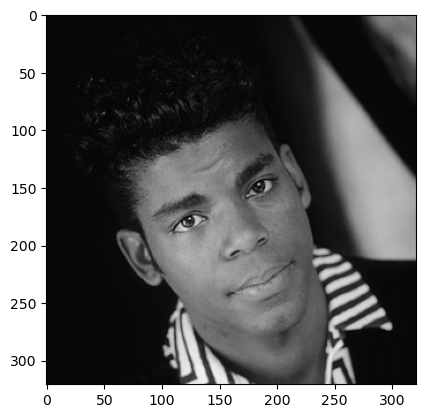

In [25]:
noise_var = 0.005  # more noise makes denoising harder, we suggest you keep this value
train_chunk_size = 128  # depends on your hardware; we recommend 128

n2ntrain_set = Noisy2NoisyImageChunkDataset(img_files=train_img_files, noise_var=noise_var, chunk_size=train_chunk_size)
# for validation and testing, we do not have to split the images into chunks because we do not have to compute gradients
# the images have shape (321, 481) or (481, 321) so we crop them to (321, 321) to facilitate data loading
n2nval_set = Noisy2NoisyImageChunkDataset(img_files=val_img_files, noise_var=noise_var, chunk_size=321)
n2ntest_set = Noisy2NoisyImageChunkDataset(img_files=test_img_files, noise_var=noise_var, chunk_size=321)

plt.imshow(n2nval_set[0][0], cmap="gray")

In [26]:
batch_size = 32  # depends on your hardware

n2ntrain_loader = DataLoader(n2ntrain_set, batch_size=batch_size)
n2nval_loader = DataLoader(n2nval_set, batch_size=batch_size)
n2ntest_loader = DataLoader(n2ntest_set, batch_size=batch_size)

In [16]:
# more pooling layers and convolutional kernels increase the complexity of the U-Net (see lecture notes)
num_pool_layers = 2
chans = 64
device = "cpu"  # set to "cuda" or "cuda:0" if you have access to a GPU (e.g. via Google Colab)

model2 = Unet(
    in_chans=1,  # 1 input channel as we use grayscale images as input
    out_chans=1,  # 1 output channel as the model returns grayscale images
    num_pool_layers=num_pool_layers,
    chans=chans
)
model2 = model2.to(device)

In [19]:
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)  # choose a suitable optimizer form torch.optim; we recommend to use the ADAM optimizer

epochs = 5  # how many epochs to train
check_val_every_epochs = 1


for e in range(epochs):
    train_loss2 = 0.0
    for imgs_noisy1, imgs_noisy2, _ in tqdm.tqdm(n2ntrain_loader, desc=f"Training Epoch {e}"):
        imgs_noisy1 = imgs_noisy1.to(device)
        imgs_noisy2 = imgs_noisy2.to(device)
        # clear the gradients
        optimizer.zero_grad()
        # normalize input
        mean = imgs_noisy1.mean(dim=(-1, -2), keepdim=True)
        std = imgs_noisy1.std(dim=(-1, -2), keepdim=True)
        imgs_noisy1 = (imgs_noisy1 - mean) / std
        # forward pass
        f_im_noisy1 = model2(imgs_noisy1.unsqueeze(1)).squeeze(1)
        # undo normalizaiton
        f_im_noisy1 = f_im_noisy1 * std + mean
        # find the Loss
        loss = get_training_loss(f_im_noisy1, imgs_noisy2).mean()
        # calculate gradients 
        loss.backward()
        # update Weights
        optimizer.step()
        # update epoch loss
        train_loss2 += loss.item() # Since it is a torch tensor, we need to use .item() to get the value
    train_loss2 /= len(n2ntrain_loader)
    print(f'Training Loss: {train_loss2}')
    
    if e % check_val_every_epochs == 0:
        with torch.no_grad():
            val_psnr = 0.0
            for imgs_noisy1, imgs_noisy2, imgs_clean in tqdm.tqdm(n2nval_loader, desc=f"Validation Epoch {e}"):
                imgs_noisy1 = imgs_noisy1.to(device)
                imgs_noisy2 = imgs_noisy2.to(device)
                mean = imgs_noisy1.mean(dim=(-1, -2), keepdim=True)
                std = imgs_noisy1.std(dim=(-1, -2), keepdim=True)
                imgs_noisy1 = (imgs_noisy1 - mean) / std
                f_im_noisy1 = model(imgs_noisy1.unsqueeze(1)).squeeze(1)
                f_im_noisy1 = f_im_noisy1 * std + mean
                psnr = get_psnr(f_im_noisy1, imgs_clean).mean()
                val_psnr += psnr.item()
            val_psnr /= len(val_loader)
            print(f'Validation PSNR: {val_psnr}')

Training Epoch 0: 100%|██████████| 38/38 [04:21<00:00,  6.88s/it]


Training Loss: 0.00674431847016278


Validation Epoch 0: 100%|██████████| 2/2 [00:22<00:00, 11.42s/it]


Validation PSNR: 21.8458251953125


Training Epoch 1: 100%|██████████| 38/38 [04:17<00:00,  6.77s/it]


Training Loss: 0.006546991705698402


Validation Epoch 1: 100%|██████████| 2/2 [00:21<00:00, 10.98s/it]


Validation PSNR: 21.8458251953125


Training Epoch 2: 100%|██████████| 38/38 [04:08<00:00,  6.53s/it]


Training Loss: 0.006451807965181376


Validation Epoch 2: 100%|██████████| 2/2 [00:21<00:00, 10.74s/it]


Validation PSNR: 21.8458251953125


Training Epoch 3: 100%|██████████| 38/38 [04:07<00:00,  6.52s/it]


Training Loss: 0.0063779257899640425


Validation Epoch 3: 100%|██████████| 2/2 [00:22<00:00, 11.27s/it]


Validation PSNR: 21.8458251953125


Training Epoch 4: 100%|██████████| 38/38 [04:13<00:00,  6.66s/it]


Training Loss: 0.006325918605158988


Validation Epoch 4: 100%|██████████| 2/2 [00:21<00:00, 10.70s/it]

Validation PSNR: 21.8458251953125


In [31]:
with torch.no_grad():
    test_psnr = 0.0
    base_psnr = 0.0
    for imgs_noisy1, imgs_noisy2 in tqdm.tqdm(test_loader, desc="Testing"):
        imgs_noisy1 = imgs_noisy1.to(device)
        imgs_noisy2 = imgs_noisy2.to(device)
        mean = imgs_noisy1.mean(dim=(-1, -2), keepdim=True)
        std = imgs_noisy1.std(dim=(-1, -2), keepdim=True)
        imgs_noisy1 = (imgs_noisy1 - mean) / std
        f_im_noisy1 = model(imgs_noisy1.unsqueeze(1)).squeeze(1)
        f_im_noisy1 = (f_im_noisy1 * std) + mean
        test_psnr += get_psnr(f_im_noisy1, imgs_noisy2).mean().item()
        # base_psnr += get_psnr(imgs_clean, imgs_noisy).mean().item()
    test_psnr /= len(test_loader)
    # base_psnr /= len(test_loader)
    # print(f"PSNR of noisy images: {base_psnr}")
    print(f'PSNR of denoised images: {test_psnr}')

Testing: 100%|██████████| 2/2 [00:24<00:00, 12.08s/it]

PSNR of denoised images: 27.870991706848145
